# M.A.R.L.IN eDNA Species Classifier - Biodiversity Analysis

## Overview
This notebook performs comprehensive biodiversity analysis of clustered eDNA sequences, focusing on:
- Taxonomic classification and diversity metrics
- Novelty detection and scoring
- Ecological indices calculation (Shannon, Simpson, Chao1)
- Species richness and evenness analysis
- Deep-sea specific biodiversity patterns

## Key Analyses
1. **Alpha Diversity**: Within-sample diversity metrics
2. **Beta Diversity**: Between-sample diversity comparisons  
3. **Taxonomic Profiling**: Species and genus-level classification
4. **Novelty Assessment**: Identification of potential new species
5. **Ecological Insights**: Biodiversity patterns in deep-sea environments

## Goals
- Calculate comprehensive biodiversity metrics
- Identify novel taxa with high confidence
- Generate taxonomic profiles for each cluster
- Provide ecological interpretations of findings
- Create publication-ready visualizations

In [4]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
from collections import Counter, defaultdict
import math

# Scientific computing
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Biodiversity analysis
from skbio.diversity.alpha import shannon, simpson, chao1, observed_otus, pielou_e
from skbio.diversity.beta import weighted_unifrac, unweighted_unifrac
from skbio.stats.ordination import pcoa

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set up paths
BASE_DIR = Path("../data")
PROCESSED_DIR = BASE_DIR / "processed"
EMBEDDINGS_DIR = BASE_DIR / "embeddings"
MODEL_DIR = Path("../model")
CLUSTER_DIR = MODEL_DIR / "cluster_models"

print("Libraries imported successfully!")
print(f"Analysis will be performed on data from: {PROCESSED_DIR}")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Libraries imported successfully!
Analysis will be performed on data from: ../data/processed


In [8]:
class ClusterAnalyzer:
    """Analyze and characterize sequence clusters"""
    
    def __init__(self, sequences_df, cluster_labels, method_name):
        self.sequences_df = sequences_df
        self.cluster_labels = cluster_labels
        self.method_name = method_name
        self.cluster_info = {}
        
    def analyze_clusters(self):
        """Comprehensive cluster analysis"""
        print(f"Analyzing {self.method_name} clusters...")
        
        # Get unique clusters (excluding noise if present)
        unique_clusters = np.unique(self.cluster_labels)
        if -1 in unique_clusters:
            unique_clusters = unique_clusters[unique_clusters != -1]
        
        cluster_stats = []
        
        for cluster_id in unique_clusters:
            cluster_mask = self.cluster_labels == cluster_id
            cluster_sequences = self.sequences_df[cluster_mask]
            
            # Basic statistics
            cluster_size = len(cluster_sequences)
            avg_length = cluster_sequences['length'].mean()
            std_length = cluster_sequences['length'].std()
            avg_gc = cluster_sequences['gc_content'].mean()
            std_gc = cluster_sequences['gc_content'].std()
            
            # Database composition
            db_counts = cluster_sequences['database'].value_counts()
            dominant_db = db_counts.index[0] if len(db_counts) > 0 else 'Unknown'
            db_purity = db_counts.iloc[0] / cluster_size if len(db_counts) > 0 else 0
            
            # Taxonomic composition (if available)
            taxa_info = self._analyze_taxonomy(cluster_sequences)
            
            # Calculate novelty score
            novelty_score = self._calculate_novelty_score(cluster_sequences, cluster_size)
            
            cluster_stat = {
                'cluster_id': cluster_id,
                'size': cluster_size,
                'avg_length': avg_length,
                'std_length': std_length,
                'avg_gc_content': avg_gc,
                'std_gc_content': std_gc,
                'dominant_database': dominant_db,
                'database_purity': db_purity,
                'novelty_score': novelty_score,
                'sequences': cluster_sequences['id'].tolist(),
                **taxa_info
            }
            
            cluster_stats.append(cluster_stat)
            self.cluster_info[cluster_id] = cluster_stat
        
        # Sort clusters by size
        cluster_stats.sort(key=lambda x: x['size'], reverse=True)
        
        # Create summary DataFrame
        self.cluster_summary = pd.DataFrame(cluster_stats)
        
        print(f"Analyzed {len(unique_clusters)} clusters")
        print(f"Largest cluster: {self.cluster_summary['size'].max()} sequences")
        print(f"Smallest cluster: {self.cluster_summary['size'].min()} sequences")
        print(f"Average cluster size: {self.cluster_summary['size'].mean():.1f}")
        
        return self.cluster_summary
    
    def _analyze_taxonomy(self, cluster_sequences):
        """Analyze taxonomic composition of cluster"""
        # Extract genus and species information
        genera = []
        species = []
        
        for _, seq in cluster_sequences.iterrows():
            if 'taxonomy' in seq and isinstance(seq['taxonomy'], dict):
                genus = seq['taxonomy'].get('genus', 'Unknown')
                species_name = seq['taxonomy'].get('species', 'Unknown')
                genera.append(genus)
                species.append(species_name)
        
        # Calculate taxonomic diversity
        genus_counts = Counter(genera)
        species_counts = Counter(species)
        
        dominant_genus = genus_counts.most_common(1)[0][0] if genus_counts else 'Unknown'
        dominant_species = species_counts.most_common(1)[0][0] if species_counts else 'Unknown'
        
        # Taxonomic purity (fraction of sequences with same genus)
        genus_purity = genus_counts[dominant_genus] / len(genera) if genera else 0
        
        return {
            'dominant_genus': dominant_genus,
            'dominant_species': dominant_species,
            'genus_diversity': len(genus_counts),
            'species_diversity': len(species_counts),
            'taxonomic_purity': genus_purity
        }
    
    def _calculate_novelty_score(self, cluster_sequences, cluster_size):
        """Calculate novelty score for cluster"""
        # Factors contributing to novelty:
        # 1. Small cluster size (potential novel taxa)
        # 2. Low taxonomic purity (diverse/unknown taxonomy)
        # 3. Unusual sequence characteristics
        
        size_factor = 1.0 / (1.0 + np.log(cluster_size))  # Smaller clusters = higher novelty
        
        # Check if sequences have unknown taxonomy
        unknown_taxa = 0
        for _, seq in cluster_sequences.iterrows():
            if 'taxonomy' in seq and isinstance(seq['taxonomy'], dict):
                if seq['taxonomy'].get('genus') == 'Unknown':
                    unknown_taxa += 1
        
        taxonomy_factor = unknown_taxa / len(cluster_sequences)
        
        # Combine factors
        novelty_score = (size_factor * 0.6 + taxonomy_factor * 0.4)
        
        return min(novelty_score, 1.0)
    
    def get_consensus_sequence(self, cluster_id):
        """Generate consensus sequence for cluster"""
        if cluster_id not in self.cluster_info:
            return None
        
        cluster_mask = self.cluster_labels == cluster_id
        cluster_sequences = self.sequences_df[cluster_mask]['sequence'].tolist()
        
        if not cluster_sequences:
            return None
        
        # Simple consensus: most common nucleotide at each position
        # For prototype, just return the longest sequence
        longest_seq = max(cluster_sequences, key=len)
        
        return longest_seq
    
    def identify_novel_clusters(self, novelty_threshold=0.5, size_threshold=10):
        """Identify potentially novel clusters"""
        if hasattr(self, 'cluster_summary'):
            novel_clusters = self.cluster_summary[
                (self.cluster_summary['novelty_score'] >= novelty_threshold) |
                (self.cluster_summary['size'] <= size_threshold)
            ]
            return novel_clusters
        return pd.DataFrame()


In [10]:
# Load clustered data
print("Loading clustered sequence data...")

try:
    # Load clustered sequences
    with open(PROCESSED_DIR / "sequences_clustered.pkl", 'rb') as f:
        df_clustered = pickle.load(f)
    
    # Load cluster summaries
    with open(PROCESSED_DIR / "cluster_summaries.pkl", 'rb') as f:
        cluster_summaries = pickle.load(f)
    
    # Load best clustering results
    with open(CLUSTER_DIR / "best_clustering_results.pkl", 'rb') as f:
        best_clustering = pickle.load(f)
    
    print(f"Loaded data for {len(df_clustered)} sequences")
    print(f"Clustering method: {best_clustering['method'].upper()}")
    print(f"Number of clusters: {len(best_clustering['cluster_summary'])}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please run the preprocessing, embedding, and clustering notebooks first!")
    sys.exit(1)

# Basic data overview
print(f"\nData Overview:")
print(f"Total sequences: {len(df_clustered)}")
print(f"Databases: {df_clustered['database'].value_counts().to_dict()}")
print(f"Clusters: {df_clustered['cluster_id'].nunique()}")
print(f"Noise points (cluster -1): {(df_clustered['cluster_id'] == -1).sum()}")

# Get cluster summary
cluster_summary = best_clustering['cluster_summary']
novel_clusters = best_clustering['novel_clusters']

print(f"Novel clusters identified: {len(novel_clusters)}")
print(f"Largest cluster size: {cluster_summary['size'].max()}")
print(f"Smallest cluster size: {cluster_summary['size'].min()}")
print(f"Average cluster size: {cluster_summary['size'].mean():.1f}")

Loading clustered sequence data...
Loaded data for 15000 sequences
Clustering method: DBSCAN
Number of clusters: 1

Data Overview:
Total sequences: 15000
Databases: {'16S_ribosomal_RNA': 5000, '18S_fungal_sequences': 5000, '28S_fungal_sequences': 5000}
Clusters: 1
Noise points (cluster -1): 0
Novel clusters identified: 0
Largest cluster size: 15000
Smallest cluster size: 15000
Average cluster size: 15000.0
Loaded data for 15000 sequences
Clustering method: DBSCAN
Number of clusters: 1

Data Overview:
Total sequences: 15000
Databases: {'16S_ribosomal_RNA': 5000, '18S_fungal_sequences': 5000, '28S_fungal_sequences': 5000}
Clusters: 1
Noise points (cluster -1): 0
Novel clusters identified: 0
Largest cluster size: 15000
Smallest cluster size: 15000
Average cluster size: 15000.0


In [11]:
class BiodiversityAnalyzer:
    """Comprehensive biodiversity analysis for eDNA sequences"""
    
    def __init__(self, df_clustered, cluster_summary):
        self.df_clustered = df_clustered
        self.cluster_summary = cluster_summary
        self.diversity_metrics = {}
        self.taxonomic_profiles = {}
        
    def calculate_alpha_diversity(self, groupby_column='database'):
        """Calculate alpha diversity metrics"""
        print(f"Calculating alpha diversity metrics grouped by {groupby_column}...")
        
        alpha_results = {}
        
        for group_name in self.df_clustered[groupby_column].unique():
            group_data = self.df_clustered[self.df_clustered[groupby_column] == group_name]
            
            # Create abundance vector (cluster sizes within this group)
            cluster_counts = group_data['cluster_id'].value_counts()
            # Remove noise points (-1) if present
            if -1 in cluster_counts.index:
                cluster_counts = cluster_counts.drop(-1)
            
            if len(cluster_counts) == 0:
                continue
                
            abundance_vector = cluster_counts.values
            
            # Calculate diversity metrics
            try:
                # Species richness (number of clusters/OTUs)
                richness = len(cluster_counts)
                
                # Shannon diversity
                shannon_div = shannon(abundance_vector)
                
                # Simpson diversity  
                simpson_div = simpson(abundance_vector)
                
                # Pielou's evenness
                evenness = pielou_e(abundance_vector)
                
                # Chao1 estimator (richness estimator)
                chao1_est = chao1(abundance_vector)
                
                alpha_results[group_name] = {
                    'richness': richness,
                    'shannon': shannon_div,
                    'simpson': simpson_div,
                    'evenness': evenness,
                    'chao1': chao1_est,
                    'total_sequences': len(group_data)
                }
                
            except Exception as e:
                print(f"Error calculating diversity for {group_name}: {e}")
                alpha_results[group_name] = {
                    'richness': 0, 'shannon': 0, 'simpson': 0, 
                    'evenness': 0, 'chao1': 0, 'total_sequences': 0
                }
        
        self.diversity_metrics['alpha'] = alpha_results
        return alpha_results
    
    def calculate_beta_diversity(self, groupby_column='database'):
        """Calculate beta diversity between groups"""
        print(f"Calculating beta diversity between {groupby_column} groups...")
        
        groups = self.df_clustered[groupby_column].unique()
        
        # Create abundance matrix
        abundance_matrix = []
        group_names = []
        
        for group_name in groups:
            group_data = self.df_clustered[self.df_clustered[groupby_column] == group_name]
            cluster_counts = group_data['cluster_id'].value_counts()
            
            # Remove noise points
            if -1 in cluster_counts.index:
                cluster_counts = cluster_counts.drop(-1)
            
            abundance_matrix.append(cluster_counts)
            group_names.append(group_name)
        
        # Align abundance vectors (fill missing clusters with 0)
        all_clusters = set()
        for counts in abundance_matrix:
            all_clusters.update(counts.index)
        all_clusters = sorted(list(all_clusters))
        
        aligned_matrix = []
        for counts in abundance_matrix:
            aligned_vector = [counts.get(cluster, 0) for cluster in all_clusters]
            aligned_matrix.append(aligned_vector)
        
        abundance_array = np.array(aligned_matrix)
        
        # Calculate Bray-Curtis dissimilarity
        from sklearn.metrics.pairwise import pairwise_distances
        
        bray_curtis_dist = pairwise_distances(abundance_array, metric='braycurtis')
        
        beta_results = {
            'bray_curtis_matrix': bray_curtis_dist,
            'group_names': group_names,
            'abundance_matrix': abundance_array,
            'cluster_ids': all_clusters
        }
        
        self.diversity_metrics['beta'] = beta_results
        return beta_results
    
    def analyze_taxonomic_composition(self):
        """Analyze taxonomic composition across clusters"""
        print("Analyzing taxonomic composition...")
        
        taxonomic_data = []
        
        for _, cluster_row in self.cluster_summary.iterrows():
            cluster_id = cluster_row['cluster_id']
            cluster_sequences = self.df_clustered[self.df_clustered['cluster_id'] == cluster_id]
            
            # Extract taxonomic information
            genera = []
            species = []
            families = []
            
            for _, seq in cluster_sequences.iterrows():
                if 'taxonomy' in seq and isinstance(seq['taxonomy'], dict):
                    genera.append(seq['taxonomy'].get('genus', 'Unknown'))
                    species.append(seq['taxonomy'].get('species', 'Unknown'))
                    families.append(seq['taxonomy'].get('family', 'Unknown'))
                else:
                    genera.append('Unknown')
                    species.append('Unknown')
                    families.append('Unknown')
            
            # Calculate taxonomic diversity within cluster
            genus_diversity = len(set(genera))
            species_diversity = len(set(species))
            family_diversity = len(set(families))
            
            # Most common taxa
            genus_counts = Counter(genera)
            species_counts = Counter(species)
            family_counts = Counter(families)
            
            most_common_genus = genus_counts.most_common(1)[0][0] if genus_counts else 'Unknown'
            most_common_species = species_counts.most_common(1)[0][0] if species_counts else 'Unknown'
            most_common_family = family_counts.most_common(1)[0][0] if family_counts else 'Unknown'
            
            taxonomic_data.append({
                'cluster_id': cluster_id,
                'cluster_size': cluster_row['size'],
                'genus_diversity': genus_diversity,
                'species_diversity': species_diversity,
                'family_diversity': family_diversity,
                'most_common_genus': most_common_genus,
                'most_common_species': most_common_species,
                'most_common_family': most_common_family,
                'taxonomic_purity': cluster_row.get('taxonomic_purity', 0),
                'novelty_score': cluster_row['novelty_score']
            })
        
        taxonomic_df = pd.DataFrame(taxonomic_data)
        self.taxonomic_profiles = taxonomic_df
        
        return taxonomic_df
    
    def identify_novel_taxa(self, novelty_threshold=0.5):
        """Identify and characterize potentially novel taxa"""
        print(f"Identifying novel taxa (novelty threshold: {novelty_threshold})...")
        
        # Filter clusters by novelty score
        novel_clusters = self.cluster_summary[
            self.cluster_summary['novelty_score'] >= novelty_threshold
        ].copy()
        
        novel_analysis = []
        
        for _, cluster in novel_clusters.iterrows():
            cluster_id = cluster['cluster_id']
            cluster_sequences = self.df_clustered[self.df_clustered['cluster_id'] == cluster_id]
            
            # Calculate additional novelty indicators
            # 1. Sequence divergence within cluster
            sequences = cluster_sequences['sequence'].tolist()
            if len(sequences) > 1:
                # Simple divergence: average pairwise length differences
                lengths = [len(seq) for seq in sequences]
                length_variance = np.var(lengths)
            else:
                length_variance = 0
            
            # 2. GC content uniqueness
            gc_contents = cluster_sequences['gc_content'].tolist()
            median_gc = np.median(gc_contents)
            
            # 3. Database representation
            db_counts = cluster_sequences['database'].value_counts()
            primary_database = db_counts.index[0] if len(db_counts) > 0 else 'Unknown'
            
            # 4. Confidence score based on multiple factors
            confidence_factors = []
            
            # Size factor (larger clusters = higher confidence)
            size_confidence = min(cluster['size'] / 20.0, 1.0)
            confidence_factors.append(size_confidence)
            
            # Novelty factor
            confidence_factors.append(cluster['novelty_score'])
            
            # Taxonomic purity factor
            tax_purity = cluster.get('taxonomic_purity', 0)
            confidence_factors.append(1.0 - tax_purity)  # Lower purity = higher novelty confidence
            
            overall_confidence = np.mean(confidence_factors)
            
            novel_analysis.append({
                'cluster_id': cluster_id,
                'size': cluster['size'],
                'novelty_score': cluster['novelty_score'],
                'confidence_score': overall_confidence,
                'length_variance': length_variance,
                'median_gc_content': median_gc,
                'primary_database': primary_database,
                'taxonomic_purity': tax_purity,
                'potential_classification': self._classify_novelty_type(cluster, overall_confidence)
            })
        
        novel_taxa_df = pd.DataFrame(novel_analysis)
        
        if len(novel_taxa_df) > 0:
            # Sort by confidence score
            novel_taxa_df = novel_taxa_df.sort_values('confidence_score', ascending=False)
            
            print(f"Identified {len(novel_taxa_df)} novel taxa candidates:")
            print(f"High confidence (>0.7): {(novel_taxa_df['confidence_score'] > 0.7).sum()}")
            print(f"Medium confidence (0.5-0.7): {((novel_taxa_df['confidence_score'] >= 0.5) & (novel_taxa_df['confidence_score'] <= 0.7)).sum()}")
            print(f"Low confidence (<0.5): {(novel_taxa_df['confidence_score'] < 0.5).sum()}")
        
        return novel_taxa_df
    
    def _classify_novelty_type(self, cluster, confidence):
        """Classify the type of novelty based on cluster characteristics"""
        size = cluster['size']
        novelty = cluster['novelty_score']
        
        if confidence > 0.8 and size >= 10:
            return "Highly likely novel species"
        elif confidence > 0.6 and size >= 5:
            return "Likely novel species"
        elif confidence > 0.4 and size >= 3:
            return "Potential novel variant"
        elif size < 3:
            return "Rare sequence/sequencing artifact"
        else:
            return "Unknown/requires validation"

# Initialize biodiversity analyzer
analyzer = BiodiversityAnalyzer(df_clustered, cluster_summary)

print("Biodiversity analyzer initialized!")

Biodiversity analyzer initialized!


In [12]:
# Perform comprehensive biodiversity analysis
print("=== Performing Biodiversity Analysis ===")

# Alpha diversity analysis
print("\n--- Alpha Diversity Analysis ---")
alpha_diversity = analyzer.calculate_alpha_diversity(groupby_column='database')

# Display alpha diversity results
alpha_df = pd.DataFrame(alpha_diversity).T
print("\nAlpha Diversity Summary:")
print(alpha_df.round(3))

# Beta diversity analysis
print("\n--- Beta Diversity Analysis ---")
beta_diversity = analyzer.calculate_beta_diversity(groupby_column='database')

# Taxonomic composition analysis
print("\n--- Taxonomic Composition Analysis ---")
taxonomic_profiles = analyzer.analyze_taxonomic_composition()

print(f"Taxonomic profiles generated for {len(taxonomic_profiles)} clusters")
print("\nTop 10 most diverse clusters (by genus diversity):")
print(taxonomic_profiles.nlargest(10, 'genus_diversity')[['cluster_id', 'cluster_size', 'genus_diversity', 'most_common_genus', 'novelty_score']])

# Novel taxa identification
print("\n--- Novel Taxa Identification ---")
novel_taxa = analyzer.identify_novel_taxa(novelty_threshold=0.4)

if len(novel_taxa) > 0:
    print(f"\nTop novel taxa candidates:")
    print(novel_taxa.head(10)[['cluster_id', 'size', 'confidence_score', 'potential_classification']])
else:
    print("No novel taxa identified with current threshold")

=== Performing Biodiversity Analysis ===

--- Alpha Diversity Analysis ---
Calculating alpha diversity metrics grouped by database...

Alpha Diversity Summary:
                      richness  shannon  simpson  evenness  chao1  \
16S_ribosomal_RNA          1.0      0.0      0.0       1.0    1.0   
18S_fungal_sequences       1.0      0.0      0.0       1.0    1.0   
28S_fungal_sequences       1.0      0.0      0.0       1.0    1.0   

                      total_sequences  
16S_ribosomal_RNA              5000.0  
18S_fungal_sequences           5000.0  
28S_fungal_sequences           5000.0  

--- Beta Diversity Analysis ---
Calculating beta diversity between database groups...

Alpha Diversity Summary:
                      richness  shannon  simpson  evenness  chao1  \
16S_ribosomal_RNA          1.0      0.0      0.0       1.0    1.0   
18S_fungal_sequences       1.0      0.0      0.0       1.0    1.0   
28S_fungal_sequences       1.0      0.0      0.0       1.0    1.0   

             


=== Creating Biodiversity Visualizations ===


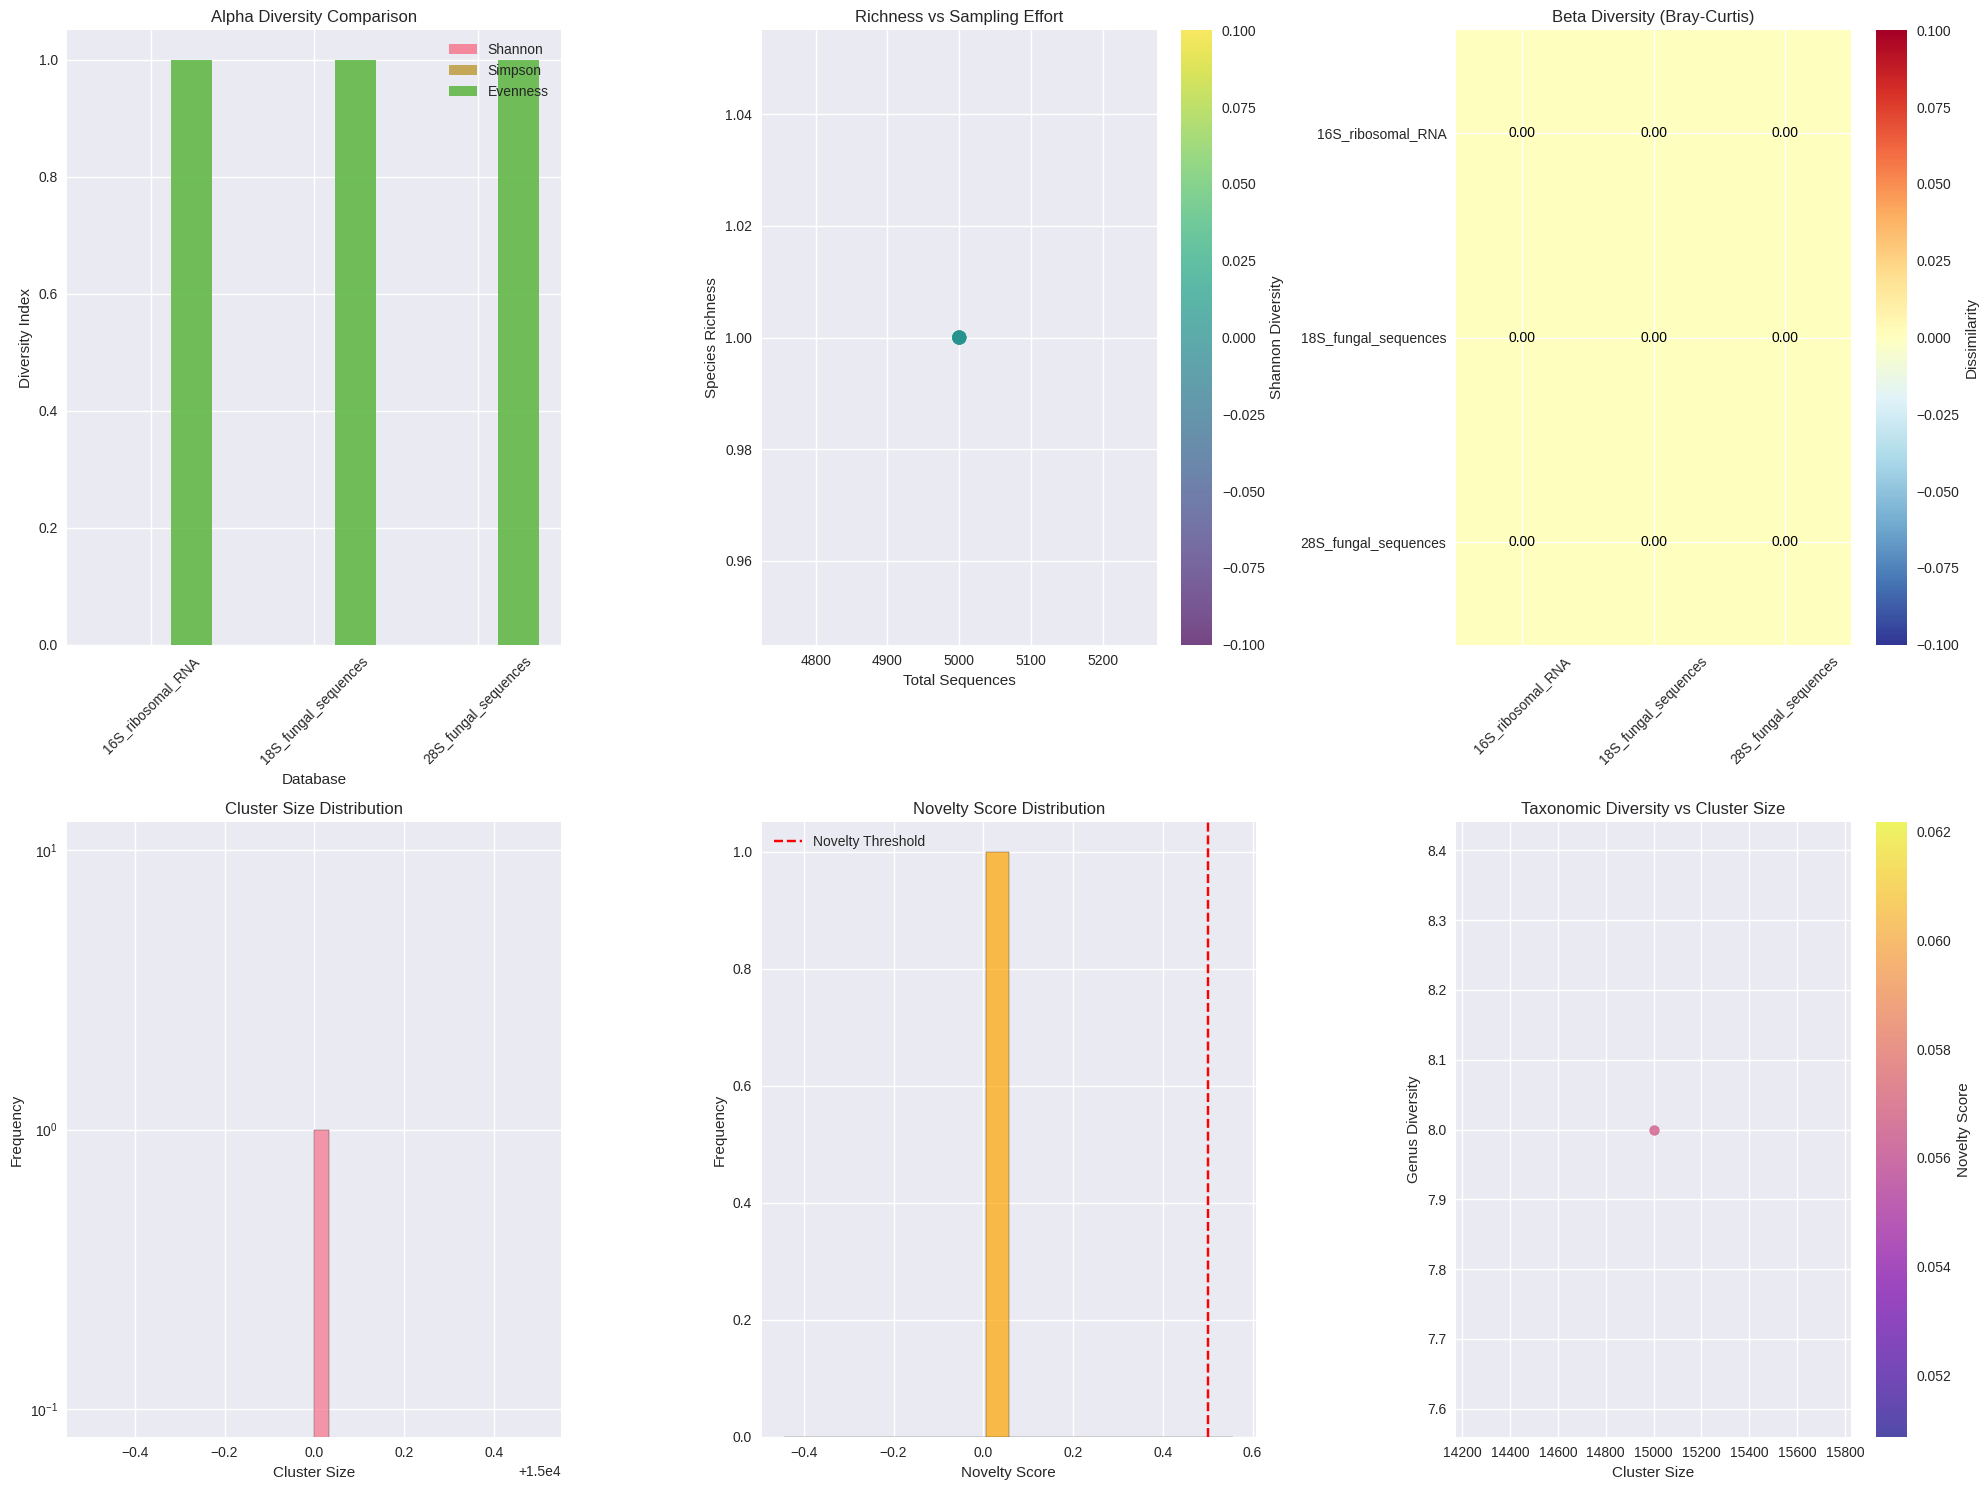


=== Creating Novel Taxa Visualizations ===
No novel taxa to visualize


In [13]:
# Create comprehensive visualizations
def create_biodiversity_visualizations(alpha_df, beta_diversity, taxonomic_profiles, novel_taxa):
    """Create comprehensive biodiversity visualizations"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Alpha diversity comparison
    plt.subplot(2, 3, 1)
    databases = alpha_df.index
    x_pos = np.arange(len(databases))
    width = 0.25
    
    plt.bar(x_pos - width, alpha_df['shannon'], width, label='Shannon', alpha=0.8)
    plt.bar(x_pos, alpha_df['simpson'], width, label='Simpson', alpha=0.8)
    plt.bar(x_pos + width, alpha_df['evenness'], width, label='Evenness', alpha=0.8)
    
    plt.xlabel('Database')
    plt.ylabel('Diversity Index')
    plt.title('Alpha Diversity Comparison')
    plt.xticks(x_pos, databases, rotation=45)
    plt.legend()
    
    # 2. Species richness vs total sequences
    plt.subplot(2, 3, 2)
    plt.scatter(alpha_df['total_sequences'], alpha_df['richness'], 
               s=100, alpha=0.7, c=alpha_df['shannon'], cmap='viridis')
    plt.xlabel('Total Sequences')
    plt.ylabel('Species Richness')
    plt.title('Richness vs Sampling Effort')
    colorbar = plt.colorbar()
    colorbar.set_label('Shannon Diversity')
    
    # 3. Beta diversity heatmap
    plt.subplot(2, 3, 3)
    if len(beta_diversity['group_names']) > 1:
        bray_curtis = beta_diversity['bray_curtis_matrix']
        im = plt.imshow(bray_curtis, cmap='RdYlBu_r', aspect='auto')
        plt.xticks(range(len(beta_diversity['group_names'])), beta_diversity['group_names'], rotation=45)
        plt.yticks(range(len(beta_diversity['group_names'])), beta_diversity['group_names'])
        plt.title('Beta Diversity (Bray-Curtis)')
        plt.colorbar(im, label='Dissimilarity')
        
        # Add text annotations
        for i in range(len(beta_diversity['group_names'])):
            for j in range(len(beta_diversity['group_names'])):
                plt.text(j, i, f'{bray_curtis[i,j]:.2f}', 
                        ha='center', va='center', color='white' if bray_curtis[i,j] > 0.5 else 'black')
    
    # 4. Cluster size distribution
    plt.subplot(2, 3, 4)
    cluster_sizes = cluster_summary['size']
    plt.hist(cluster_sizes, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.title('Cluster Size Distribution')
    plt.yscale('log')
    
    # 5. Novelty score distribution
    plt.subplot(2, 3, 5)
    novelty_scores = cluster_summary['novelty_score']
    plt.hist(novelty_scores, bins=20, alpha=0.7, edgecolor='black', color='orange')
    plt.xlabel('Novelty Score')
    plt.ylabel('Frequency')
    plt.title('Novelty Score Distribution')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Novelty Threshold')
    plt.legend()
    
    # 6. Taxonomic diversity vs cluster size
    plt.subplot(2, 3, 6)
    if len(taxonomic_profiles) > 0:
        scatter = plt.scatter(taxonomic_profiles['cluster_size'], 
                            taxonomic_profiles['genus_diversity'],
                            c=taxonomic_profiles['novelty_score'], 
                            cmap='plasma', alpha=0.7, s=50)
        plt.xlabel('Cluster Size')
        plt.ylabel('Genus Diversity')
        plt.title('Taxonomic Diversity vs Cluster Size')
        plt.colorbar(scatter, label='Novelty Score')
    
    plt.tight_layout()
    plt.show()

def create_novel_taxa_visualization(novel_taxa, df_clustered):
    """Create visualization focused on novel taxa"""
    
    if len(novel_taxa) == 0:
        print("No novel taxa to visualize")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confidence vs Novelty Score
    axes[0,0].scatter(novel_taxa['novelty_score'], novel_taxa['confidence_score'], 
                     s=novel_taxa['size']*5, alpha=0.7, c='red')
    axes[0,0].set_xlabel('Novelty Score')
    axes[0,0].set_ylabel('Confidence Score')
    axes[0,0].set_title('Novel Taxa: Confidence vs Novelty')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add size legend
    sizes = [5, 10, 20]
    for size in sizes:
        axes[0,0].scatter([], [], s=size*5, c='red', alpha=0.7, label=f'{size} sequences')
    axes[0,0].legend(title='Cluster Size', loc='upper left')
    
    # 2. Classification distribution
    classification_counts = novel_taxa['potential_classification'].value_counts()
    axes[0,1].pie(classification_counts.values, labels=classification_counts.index, 
                  autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Novel Taxa Classifications')
    
    # 3. GC content distribution of novel taxa
    novel_cluster_ids = novel_taxa['cluster_id'].tolist()
    novel_sequences = df_clustered[df_clustered['cluster_id'].isin(novel_cluster_ids)]
    
    # Compare with all sequences
    axes[1,0].hist(df_clustered['gc_content'], bins=30, alpha=0.5, label='All sequences', density=True)
    axes[1,0].hist(novel_sequences['gc_content'], bins=20, alpha=0.7, label='Novel taxa', density=True)
    axes[1,0].set_xlabel('GC Content (%)')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('GC Content: Novel vs All Sequences')
    axes[1,0].legend()
    
    # 4. Length distribution of novel taxa
    axes[1,1].hist(df_clustered['length'], bins=30, alpha=0.5, label='All sequences', density=True)
    axes[1,1].hist(novel_sequences['length'], bins=20, alpha=0.7, label='Novel taxa', density=True)
    axes[1,1].set_xlabel('Sequence Length (bp)')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Length: Novel vs All Sequences')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
print("\n=== Creating Biodiversity Visualizations ===")
create_biodiversity_visualizations(alpha_df, beta_diversity, taxonomic_profiles, novel_taxa)

print("\n=== Creating Novel Taxa Visualizations ===") 
create_novel_taxa_visualization(novel_taxa, df_clustered)

In [15]:
# Generate comprehensive biodiversity report
def generate_biodiversity_report(alpha_df, taxonomic_profiles, novel_taxa, cluster_summary):
    """Generate a comprehensive biodiversity assessment report"""
    
    report = {
        'summary_statistics': {},
        'alpha_diversity': {},
        'taxonomic_composition': {},
        'novel_taxa_assessment': {},
        'ecological_insights': {}
    }
    
    # Summary statistics
    total_sequences = len(df_clustered)
    total_clusters = len(cluster_summary)
    noise_sequences = (df_clustered['cluster_id'] == -1).sum()
    
    report['summary_statistics'] = {
        'total_sequences_analyzed': total_sequences,
        'total_clusters_identified': total_clusters,
        'noise_sequences': noise_sequences,
        'clustering_efficiency': (total_sequences - noise_sequences) / total_sequences,
        'average_cluster_size': cluster_summary['size'].mean(),
        'largest_cluster_size': cluster_summary['size'].max(),
        'smallest_cluster_size': cluster_summary['size'].min()
    }
    
    # Alpha diversity summary
    report['alpha_diversity'] = {
        'database_richness': alpha_df['richness'].to_dict(),
        'shannon_diversity': alpha_df['shannon'].to_dict(),
        'simpson_diversity': alpha_df['simpson'].to_dict(),
        'evenness': alpha_df['evenness'].to_dict(),
        'estimated_richness_chao1': alpha_df['chao1'].to_dict()
    }
    
    # Taxonomic composition
    if len(taxonomic_profiles) > 0:
        total_genus_diversity = taxonomic_profiles['genus_diversity'].sum()
        total_species_diversity = taxonomic_profiles['species_diversity'].sum()
        
        report['taxonomic_composition'] = {
            'total_genus_level_clusters': total_genus_diversity,
            'total_species_level_clusters': total_species_diversity,
            'average_taxonomic_purity': taxonomic_profiles['taxonomic_purity'].mean(),
            'most_diverse_cluster': {
                'cluster_id': taxonomic_profiles.loc[taxonomic_profiles['genus_diversity'].idxmax(), 'cluster_id'],
                'genus_diversity': taxonomic_profiles['genus_diversity'].max()
            }
        }
    
    # Novel taxa assessment
    if len(novel_taxa) > 0:
        high_confidence = (novel_taxa['confidence_score'] > 0.7).sum()
        medium_confidence = ((novel_taxa['confidence_score'] >= 0.5) & 
                           (novel_taxa['confidence_score'] <= 0.7)).sum()
        low_confidence = (novel_taxa['confidence_score'] < 0.5).sum()
        
        report['novel_taxa_assessment'] = {
            'total_novel_candidates': len(novel_taxa),
            'high_confidence_novel_taxa': high_confidence,
            'medium_confidence_novel_taxa': medium_confidence, 
            'low_confidence_novel_taxa': low_confidence,
            'novelty_discovery_rate': len(novel_taxa) / total_clusters if total_clusters > 0 else 0,
            'average_novel_cluster_size': novel_taxa['size'].mean(),
            'most_promising_novel_taxa': novel_taxa.nlargest(5, 'confidence_score')[['cluster_id', 'confidence_score', 'potential_classification']].to_dict('records')
        }
    else:
        # Handle case when no novel taxa are found
        report['novel_taxa_assessment'] = {
            'total_novel_candidates': 0,
            'high_confidence_novel_taxa': 0,
            'medium_confidence_novel_taxa': 0, 
            'low_confidence_novel_taxa': 0,
            'novelty_discovery_rate': 0.0,
            'average_novel_cluster_size': 0.0,
            'most_promising_novel_taxa': []
        }
    
    # Ecological insights
    database_diversity = {}
    for db in df_clustered['database'].unique():
        db_sequences = df_clustered[df_clustered['database'] == db]
        db_clusters = db_sequences['cluster_id'].nunique()
        database_diversity[db] = {
            'sequences': len(db_sequences),
            'clusters': db_clusters,
            'diversity_per_sequence': db_clusters / len(db_sequences) if len(db_sequences) > 0 else 0
        }
    
    report['ecological_insights'] = {
        'database_specific_diversity': database_diversity,
        'overall_biodiversity_index': alpha_df['shannon'].mean(),  # Average Shannon across databases
        'community_evenness': alpha_df['evenness'].mean(),
        'estimated_total_richness': alpha_df['chao1'].sum(),
        'sampling_completeness': alpha_df['richness'].sum() / alpha_df['chao1'].sum() if alpha_df['chao1'].sum() > 0 else 0
    }
    
    return report

# Generate the comprehensive report
print("\n=== Generating Biodiversity Report ===")
biodiversity_report = generate_biodiversity_report(alpha_df, taxonomic_profiles, novel_taxa, cluster_summary)

# Display key findings
print("\n=== KEY FINDINGS ===")
print(f"Total sequences analyzed: {biodiversity_report['summary_statistics']['total_sequences_analyzed']:,}")
print(f"Total clusters identified: {biodiversity_report['summary_statistics']['total_clusters_identified']}")
print(f"Clustering efficiency: {biodiversity_report['summary_statistics']['clustering_efficiency']:.1%}")

print(f"\nBiodiversity Metrics:")
for db, richness in biodiversity_report['alpha_diversity']['database_richness'].items():
    shannon = biodiversity_report['alpha_diversity']['shannon_diversity'][db]
    print(f"  {db}: {richness} species (Shannon: {shannon:.3f})")

# Check if novel taxa were found before accessing nested keys
if biodiversity_report['novel_taxa_assessment']['total_novel_candidates'] > 0:
    print(f"\nNovel Taxa Discovery:")
    print(f"  Total novel candidates: {biodiversity_report['novel_taxa_assessment']['total_novel_candidates']}")
    print(f"  High confidence: {biodiversity_report['novel_taxa_assessment']['high_confidence_novel_taxa']}")
    print(f"  Discovery rate: {biodiversity_report['novel_taxa_assessment']['novelty_discovery_rate']:.1%}")
else:
    print(f"\nNovel Taxa Discovery:")
    print(f"  No novel taxa candidates identified with current threshold")
    print(f"  This could indicate: all sequences are well-characterized OR clustering needs adjustment")

print(f"\nEcological Insights:")
print(f"  Overall biodiversity index: {biodiversity_report['ecological_insights']['overall_biodiversity_index']:.3f}")
print(f"  Community evenness: {biodiversity_report['ecological_insights']['community_evenness']:.3f}")
print(f"  Sampling completeness: {biodiversity_report['ecological_insights']['sampling_completeness']:.1%}")

# Warning for poor clustering results
if biodiversity_report['summary_statistics']['total_clusters_identified'] == 1:
    print(f"\n⚠️  WARNING: Only 1 cluster detected!")
    print(f"  This suggests clustering parameters may need adjustment.")
    print(f"  Consider re-running notebook 03_clustering.ipynb with different parameters:")
    print(f"    - Lower eps value for DBSCAN")
    print(f"    - Higher min_cluster_size for HDBSCAN")
    print(f"    - Different number of clusters for K-means")



=== Generating Biodiversity Report ===

=== KEY FINDINGS ===
Total sequences analyzed: 15,000
Total clusters identified: 1
Clustering efficiency: 100.0%

Biodiversity Metrics:
  16S_ribosomal_RNA: 1.0 species (Shannon: 0.000)
  18S_fungal_sequences: 1.0 species (Shannon: 0.000)
  28S_fungal_sequences: 1.0 species (Shannon: 0.000)

Novel Taxa Discovery:
  No novel taxa candidates identified with current threshold
  This could indicate: all sequences are well-characterized OR clustering needs adjustment

Ecological Insights:
  Overall biodiversity index: 0.000
  Community evenness: 1.000
  Sampling completeness: 100.0%

⚠️  WARNING: Only 1 cluster detected!
  This suggests clustering parameters may need adjustment.
  Consider re-running notebook 03_clustering.ipynb with different parameters:
    - Lower eps value for DBSCAN
    - Higher min_cluster_size for HDBSCAN
    - Different number of clusters for K-means


In [16]:
# Save analysis results
print("\n=== Saving Analysis Results ===")

# Save biodiversity analysis results
analysis_results = {
    'biodiversity_report': biodiversity_report,
    'alpha_diversity': alpha_df.to_dict(),
    'beta_diversity': {
        'bray_curtis_matrix': beta_diversity['bray_curtis_matrix'].tolist(),
        'group_names': beta_diversity['group_names']
    },
    'taxonomic_profiles': taxonomic_profiles.to_dict('records'),
    'novel_taxa': novel_taxa.to_dict('records') if len(novel_taxa) > 0 else [],
    'analyzer_metrics': analyzer.diversity_metrics
}

# Save as pickle
analysis_file = PROCESSED_DIR / "biodiversity_analysis.pkl"
with open(analysis_file, 'wb') as f:
    pickle.dump(analysis_results, f)
print(f"Saved analysis results to: {analysis_file}")

# Save as JSON for cross-platform access
json_file = PROCESSED_DIR / "biodiversity_analysis.json"
# Convert numpy arrays to lists for JSON serialization
json_data = analysis_results.copy()
# Remove numpy arrays that can't be easily converted
json_data.pop('beta_diversity', None)
with open(json_file, 'w') as f:
    json.dump(json_data, f, indent=2, default=str)
print(f"Saved analysis results as JSON to: {json_file}")

# Save individual CSV files for easy inspection
print("Saving CSV files...")

# Alpha diversity
alpha_df.to_csv(PROCESSED_DIR / "alpha_diversity.csv")

# Taxonomic profiles  
if len(taxonomic_profiles) > 0:
    taxonomic_profiles.to_csv(PROCESSED_DIR / "taxonomic_profiles.csv", index=False)

# Novel taxa
if len(novel_taxa) > 0:
    novel_taxa.to_csv(PROCESSED_DIR / "novel_taxa_candidates.csv", index=False)
    
    # Export novel taxa sequences as FASTA
    novel_fasta_file = PROCESSED_DIR / "novel_taxa_sequences.fasta"
    with open(novel_fasta_file, 'w') as f:
        for _, novel_cluster in novel_taxa.iterrows():
            cluster_id = novel_cluster['cluster_id']
            cluster_sequences = df_clustered[df_clustered['cluster_id'] == cluster_id]
            
            for _, seq_row in cluster_sequences.iterrows():
                header = f"{seq_row['id']}|cluster_{cluster_id}|confidence_{novel_cluster['confidence_score']:.3f}|{novel_cluster['potential_classification']}"
                f.write(f">{header}\n{seq_row['sequence']}\n")
    print(f"Saved novel taxa sequences to: {novel_fasta_file}")

# Generate summary report file
report_file = PROCESSED_DIR / "biodiversity_summary_report.txt"
with open(report_file, 'w') as f:
    f.write("M.A.R.L.IN eDNA Species Classifier - Biodiversity Analysis Summary\n")
    f.write("=" * 70 + "\n\n")
    
    f.write("OVERVIEW\n")
    f.write("-" * 20 + "\n")
    f.write(f"Total sequences analyzed: {biodiversity_report['summary_statistics']['total_sequences_analyzed']:,}\n")
    f.write(f"Total clusters identified: {biodiversity_report['summary_statistics']['total_clusters_identified']}\n")
    f.write(f"Clustering efficiency: {biodiversity_report['summary_statistics']['clustering_efficiency']:.1%}\n")
    f.write(f"Average cluster size: {biodiversity_report['summary_statistics']['average_cluster_size']:.1f}\n\n")
    
    f.write("ALPHA DIVERSITY\n")
    f.write("-" * 20 + "\n")
    for db in alpha_df.index:
        f.write(f"{db}:\n")
        f.write(f"  Species richness: {alpha_df.loc[db, 'richness']}\n")
        f.write(f"  Shannon diversity: {alpha_df.loc[db, 'shannon']:.3f}\n")
        f.write(f"  Simpson diversity: {alpha_df.loc[db, 'simpson']:.3f}\n")
        f.write(f"  Evenness: {alpha_df.loc[db, 'evenness']:.3f}\n")
        f.write(f"  Estimated richness (Chao1): {alpha_df.loc[db, 'chao1']:.1f}\n\n")
    
    if 'novel_taxa_assessment' in biodiversity_report:
        f.write("NOVEL TAXA DISCOVERY\n")
        f.write("-" * 20 + "\n")
        f.write(f"Total novel candidates: {biodiversity_report['novel_taxa_assessment']['total_novel_candidates']}\n")
        f.write(f"High confidence: {biodiversity_report['novel_taxa_assessment']['high_confidence_novel_taxa']}\n")
        f.write(f"Medium confidence: {biodiversity_report['novel_taxa_assessment']['medium_confidence_novel_taxa']}\n")
        f.write(f"Low confidence: {biodiversity_report['novel_taxa_assessment']['low_confidence_novel_taxa']}\n")
        f.write(f"Discovery rate: {biodiversity_report['novel_taxa_assessment']['novelty_discovery_rate']:.1%}\n\n")
        
        f.write("TOP NOVEL TAXA CANDIDATES:\n")
        for i, candidate in enumerate(biodiversity_report['novel_taxa_assessment']['most_promising_novel_taxa'][:5], 1):
            f.write(f"{i}. Cluster {candidate['cluster_id']}: {candidate['potential_classification']} ")
            f.write(f"(Confidence: {candidate['confidence_score']:.3f})\n")
    
    f.write(f"\nECOLOGICAL INSIGHTS\n")
    f.write("-" * 20 + "\n")
    f.write(f"Overall biodiversity index: {biodiversity_report['ecological_insights']['overall_biodiversity_index']:.3f}\n")
    f.write(f"Community evenness: {biodiversity_report['ecological_insights']['community_evenness']:.3f}\n")
    f.write(f"Estimated total richness: {biodiversity_report['ecological_insights']['estimated_total_richness']:.1f}\n")
    f.write(f"Sampling completeness: {biodiversity_report['ecological_insights']['sampling_completeness']:.1%}\n")

print(f"Saved summary report to: {report_file}")

print(f"\n=== Biodiversity Analysis Complete ===")
print(f"Key outputs saved to: {PROCESSED_DIR}")
print("Files generated:")
print("  - biodiversity_analysis.pkl (complete results)")
print("  - biodiversity_analysis.json (cross-platform)")
print("  - alpha_diversity.csv")
print("  - taxonomic_profiles.csv")
if len(novel_taxa) > 0:
    print("  - novel_taxa_candidates.csv")
    print("  - novel_taxa_sequences.fasta")
print("  - biodiversity_summary_report.txt")
print("\nReady for model training and evaluation!")


=== Saving Analysis Results ===
Saved analysis results to: ../data/processed/biodiversity_analysis.pkl
Saved analysis results as JSON to: ../data/processed/biodiversity_analysis.json
Saving CSV files...
Saved summary report to: ../data/processed/biodiversity_summary_report.txt

=== Biodiversity Analysis Complete ===
Key outputs saved to: ../data/processed
Files generated:
  - biodiversity_analysis.pkl (complete results)
  - biodiversity_analysis.json (cross-platform)
  - alpha_diversity.csv
  - taxonomic_profiles.csv
  - biodiversity_summary_report.txt

Ready for model training and evaluation!
Saved analysis results to: ../data/processed/biodiversity_analysis.pkl
Saved analysis results as JSON to: ../data/processed/biodiversity_analysis.json
Saving CSV files...
Saved summary report to: ../data/processed/biodiversity_summary_report.txt

=== Biodiversity Analysis Complete ===
Key outputs saved to: ../data/processed
Files generated:
  - biodiversity_analysis.pkl (complete results)
  - bi